## Forecasting U.S. natural gas prices

## 2. Data

In [24]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Load your dataset
gas = pd.read_csv("data/MHHNGSP.csv")
gas['observation_date'] = pd.to_datetime(gas['observation_date'])
gas.set_index('observation_date', inplace=True)
gas = gas.asfreq('MS')  # monthly data
gas.rename(columns={'MHHNGSP': 'price'}, inplace=True)

Treat this series as monthly data, with observations corresponding to the start of each month

In [40]:
print(gas.head())
print(gas.tail())
print(f"Observations: {gas.notna().sum()}")

                  price
observation_date       
1997-01-01         3.45
1997-02-01         2.15
1997-03-01         1.89
1997-04-01         2.03
1997-05-01         2.25
                  price
observation_date       
2025-06-01         3.02
2025-07-01         3.20
2025-08-01         2.91
2025-09-01         2.97
2025-10-01         3.19
Observations: price    346
dtype: int64


In [69]:
len(gas)

346

In [41]:
# Check gaps
expected = pd.date_range(gas.index.min(), gas.index.max(), freq="MS")
missing = expected.difference(gas.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


### Plot price 

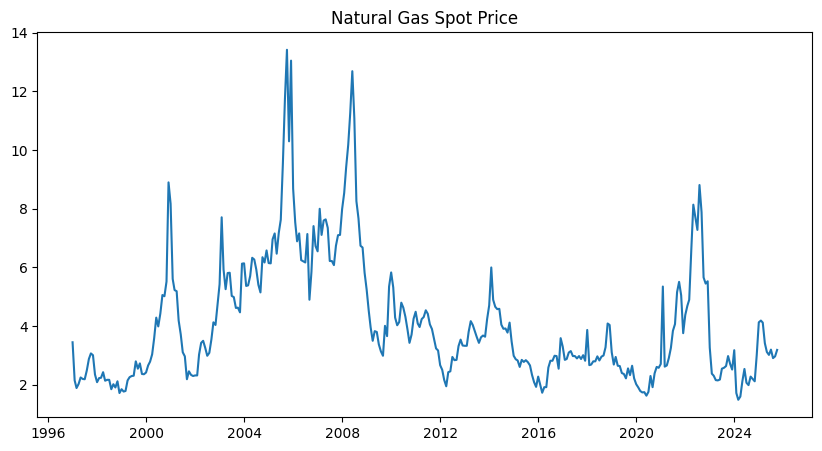

In [45]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['price'], label='Price')
plt.title("Natural Gas Spot Price")
plt.show()

### Logarithmic transformation of gas price

- Variable: Henry Hub natural gas spot price (USD/MMBtu), monthly, NSA
- Transforms: log(p_t) (variance stabilization)

In [43]:
gas['log_price'] = np.log(gas['price'])

### Plot log-level

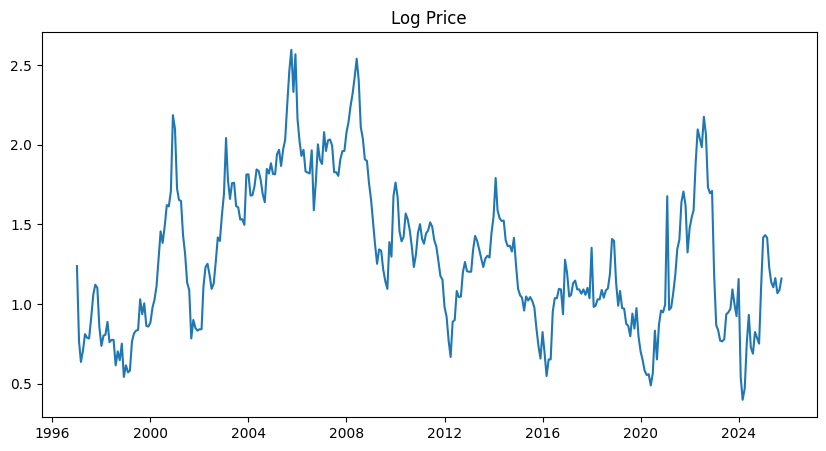

In [46]:
plt.figure(figsize=(10,5))
plt.plot(gas.index, gas['log_price'], label='Log Price')
plt.title("Log Price")
plt.show()

### ACF and PACF of Levels and Differences

(Detect trend, seasonality, cycles quantitatively)

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

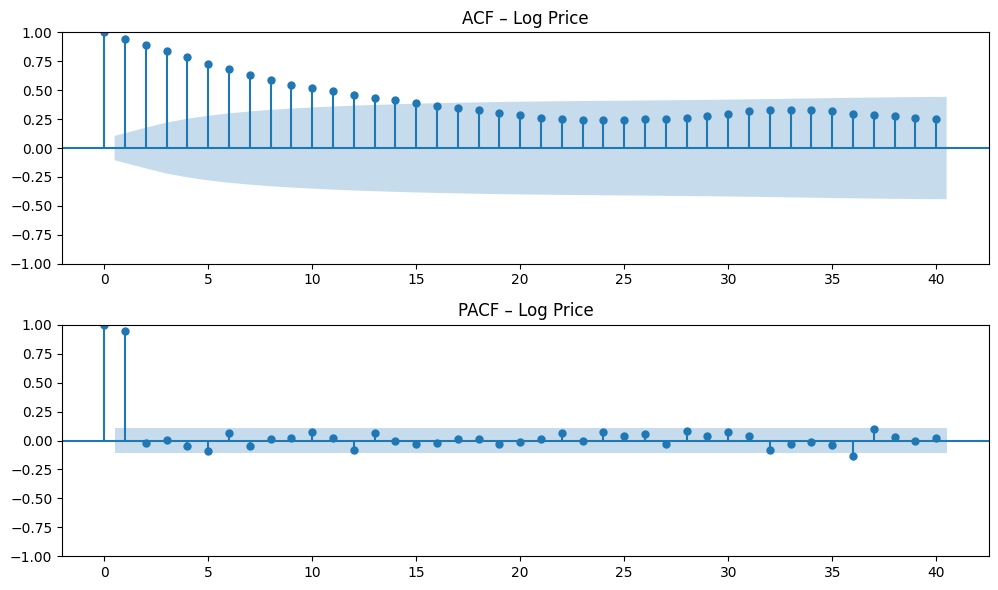

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['log_price'].dropna(), lags=40, ax=ax[0])
# ACF to see seasonal spikes at lag 12, 24
ax[0].set_title("ACF – Log Price")
plot_pacf(gas['log_price'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Log Price")
plt.tight_layout()
plt.show()


### ACF/PACF of differenced log price

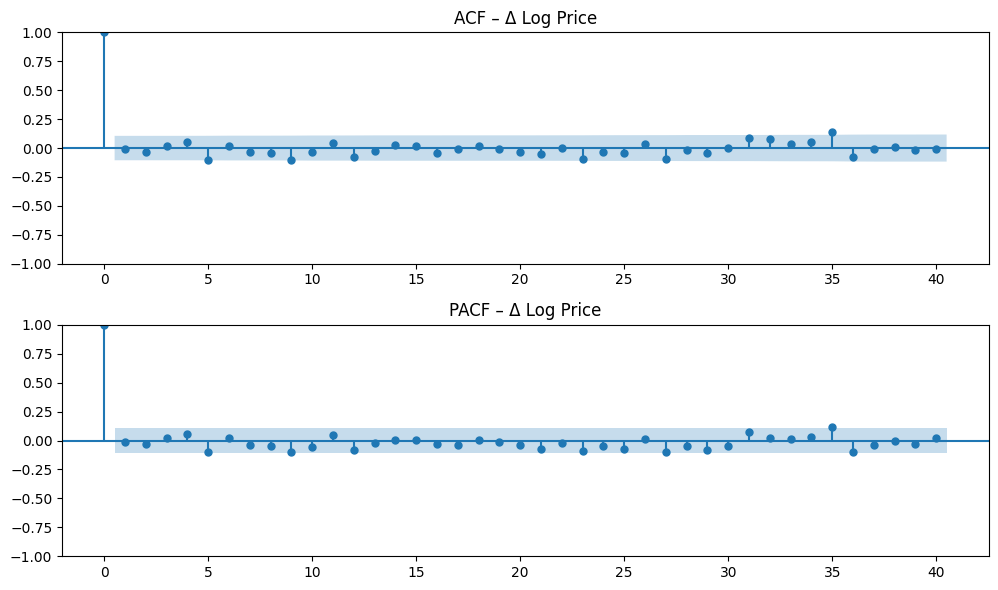

In [52]:
gas['dlog'] = gas['log_price'].diff()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(gas['dlog'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF – Δ Log Price")
plot_pacf(gas['dlog'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF – Δ Log Price")
plt.tight_layout()
plt.show()

### Check stationarity with DF test on log_price and dlog

DF (Dickey–Fuller) test: H₀ = unit root (non-stationary). Low p-value → reject non-stationary → stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = gas['log_price']
dlog_x = gas['dlog']

print("Log/Diff series:")
print("  ADF :", run_adf(log_x))
print("  ADF :", run_adf(dlog_x))

Level/log series:
  ADF : {'stat': np.float64(-3.094343749296179), 'pvalue': np.float64(0.02697461797215903)}
  ADF : {'stat': np.float64(-18.922696691951774), 'pvalue': 0.0}


## 3. Methods and models

### Model selection and justification

In [57]:
from statsmodels.tsa.arima.model import ARIMA
from pandas_datareader import data as pdr

Train/test split with last 20% as holdout

In [ ]:
# Ensure y is your monthly series (MS) with float dtype, as in your code
n = len(gas['log_price'].dropna())
h_test = max(1, int(np.floor(0.20 * n)))  # 20% holdout
y_train = gas['log_price'].iloc[:-h_test]
y_test  = gas['log_price'].iloc[-h_test:]

print(f"Train: {y_train.index[0].date()} → {y_train.index[-1].date()}  (n={len(y_train)})")
print(f"Test : {y_test.index[0].date()} → {y_test.index[-1].date()}    (n={len(y_test)})")

Train: 1997-01-01 → 2020-01-01  (n=277)
Test : 2020-02-01 → 2025-10-01    (n=69)


Helper: expanding-window ARIMA forecaster
- We'll use this for the benchmark and AR(1)

In [59]:
def rolling_arima_forecast(y, order, train_size):
    """
    y: Series (e.g. log_price)
    order: (p,d,q)
    train_size: initial length of training sample
    Returns: forecasts (Series), actuals (Series)
    """
    y = y.dropna()
    T = len(y)
    forecasts = []
    idx_fore = y.index[train_size:]  # times we forecast for

    for i in range(train_size, T):
        y_train = y.iloc[:i]
        model = ARIMA(y_train, order=order)
        fit = model.fit()
        f = fit.forecast(steps=1)[0]
        forecasts.append(f)

    forecasts = pd.Series(forecasts, index=idx_fore)
    actuals   = y.iloc[train_size:]
    return forecasts, actuals

1. Benchmark model - Random walk with drift ARIMA(0,1,0)

In [60]:
y_full = gas['log_price']
train_size = len(y_train)
# Benchmark: RW with drift (ARIMA(0,1,0))
f_rw, a_rw = rolling_arima_forecast(
    y_full,
    order=(0, 1, 0),
    train_size=train_size
)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_99108/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_99108/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_99108/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

Compute errors/RMFSE

In [61]:
def forecast_metrics(actual, forecast):
    e = actual - forecast
    rmsfe = np.sqrt(np.mean(e**2))
    mafe  = np.mean(np.abs(e))
    return rmsfe, mafe

rmsfe_rw, mafe_rw = forecast_metrics(a_rw, f_rw)
print("RW – RMSFE:", rmsfe_rw, "MAFE:", mafe_rw)

RW – RMSFE: 0.21008899757576888 MAFE: 0.14314705994892313


2. AR(1) on log price: ARIMA(1,0,0) 

In [63]:
f_ar1, a_ar1 = rolling_arima_forecast(
    y_full,
    order=(1, 0, 0),
    train_size=train_size
)

/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_99108/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_99108/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = fit.forecast(steps=1)[0]
/var/folders/x0/tmmrc_ks7q358xr7qh5mfhk00000gn/T/ipykernel_99108/2314089204.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

In [64]:
# Compute error and RMSFE
rmsfe_ar1, mafe_ar1 = forecast_metrics(a_ar1, f_ar1)
print("AR(1) – RMSFE:", rmsfe_ar1, "MAFE:", mafe_ar1)

AR(1) – RMSFE: 0.20608011609787338 MAFE: 0.14104863378361163


Data prep for Alt model 2 - AR-X with oil price

In [88]:
# Load your dataset
oil = pd.read_csv("data/DCOILWTICO.csv")
oil['observation_date'] = pd.to_datetime(oil['observation_date'])
oil.set_index('observation_date', inplace=True)
oil.rename(columns={'DCOILWTICO': 'oil_price'}, inplace=True)

In [89]:
oil = oil.resample('MS').mean()

In [90]:
expected = pd.date_range(oil.index.min(), oil.index.max(), freq="MS")
missing = expected.difference(oil.index)
print(f"Missing months: {len(missing)}")

Missing months: 0


In [91]:
print(oil.head())
print(oil.tail())
print(f"Observations: {oil.notna().sum()}")

                  oil_price
observation_date           
1997-01-01        25.131818
1997-02-01        22.176316
1997-03-01        20.965000
1997-04-01        19.695455
1997-05-01        20.819048
                  oil_price
observation_date           
2025-06-01        68.169000
2025-07-01        68.390909
2025-08-01        64.864286
2025-09-01        63.959048
2025-10-01        62.590000
Observations: oil_price    346
dtype: int64


### Plot oil

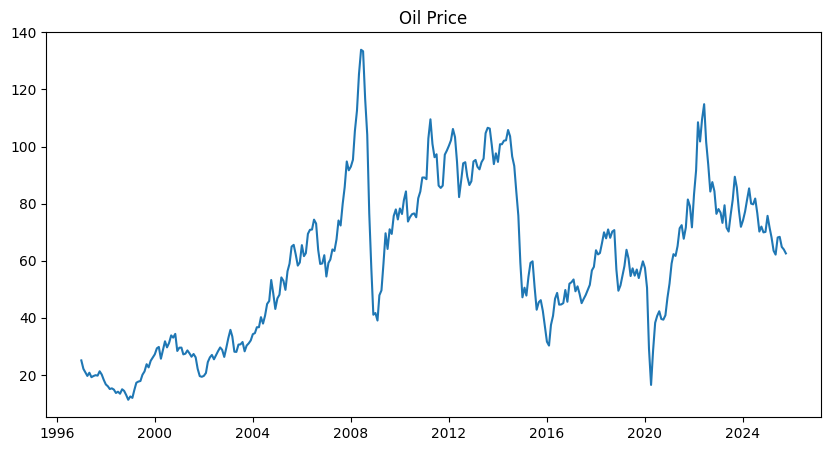

In [92]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['oil_price'], label='Price')
plt.title("Oil Price")
plt.show()

### Logarithmic transformation of oil price

In [93]:
oil['log_oil_price'] = np.log(oil['oil_price'])

In [94]:
print(oil.head())

                  oil_price  log_oil_price
observation_date                          
1997-01-01        25.131818       3.224135
1997-02-01        22.176316       3.099025
1997-03-01        20.965000       3.042854
1997-04-01        19.695455       2.980388
1997-05-01        20.819048       3.035868


### Plot log oil

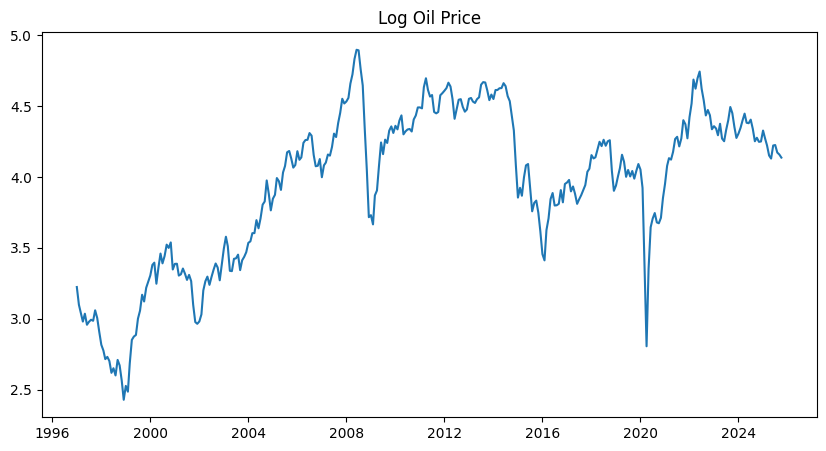

In [95]:
plt.figure(figsize=(10,5))
plt.plot(oil.index, oil['log_oil_price'], label='Price')
plt.title("Log Oil Price")
plt.show()

### Check stationarity with DF test on log_oil_price

In [98]:
def run_adf(x):
    res = adfuller(x.dropna(), autolag="AIC")
    return {"stat": res[0], "pvalue": res[1]}

log_x = oil['log_oil_price']

print("Log series:")
print("  ADF :", run_adf(log_x))

Log series:
  ADF : {'stat': np.float64(-2.283960217429215), 'pvalue': np.float64(0.17719331464393745)}


We fail to reject the null of a unit root so the series is non-stationary

### First difference

In [99]:
oil['dlog_oil'] = oil['log_oil_price'].diff()

### Check stationarity with DF test on dlog_oil

In [100]:
dlog_x = oil['dlog_oil']

print("Diff series:")
print("  ADF :", run_adf(dlog_x))

Diff series:
  ADF : {'stat': np.float64(-12.521038702549626), 'pvalue': np.float64(2.5481331700962578e-23)}


P-value is essentially zero so i strongly reject the unit root null

### Merge gas and oil series 

In [ ]:

df = gas[['log_price']].join(oil['log_oil_price'], how='inner')